In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import pdist
from sklearn.cluster import KMeans
import torch

In [ ]:
# Loading the dataset

file_path = 'Crime_Data_from_2020_to_Present.csv'

crime_data_LA = pd.read_csv(file_path)

# basic information

print(crime_data_LA.info())
print(crime_data_LA.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 944235 entries, 0 to 944234
Data columns (total 28 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DR_NO           944235 non-null  int64  
 1   Date Rptd       944235 non-null  object 
 2   DATE OCC        944235 non-null  object 
 3   TIME OCC        944235 non-null  int64  
 4   AREA            944235 non-null  int64  
 5   AREA NAME       944235 non-null  object 
 6   Rpt Dist No     944235 non-null  int64  
 7   Part 1-2        944235 non-null  int64  
 8   Crm Cd          944235 non-null  int64  
 9   Crm Cd Desc     944235 non-null  object 
 10  Mocodes         811136 non-null  object 
 11  Vict Age        944235 non-null  int64  
 12  Vict Sex        817640 non-null  object 
 13  Vict Descent    817630 non-null  object 
 14  Premis Cd       944225 non-null  float64
 15  Premis Desc     943668 non-null  object 
 16  Weapon Used Cd  324477 non-null  float64
 17  Weapon Des

In [ ]:
# missing values in Latitude and Longitude

print(crime_data_LA[['LAT', 'LON']].isnull().sum())


LAT    0
LON    0
dtype: int64


In [ ]:
# Drop rows with missing coordinates

crime_data_LA= crime_data_LA.dropna(subset=['LAT', 'LON'])

# check duplicate rows and drop them

crime_data_LA = crime_data_LA.drop_duplicates()


In [ ]:
# Geographical bounds of Chicago (Source: Google)

min_lat, max_lat = 33.700, 34.350
min_long, max_long = -118.670, -118.150

# rows within the geographic bounds for Chicago

bound_data = crime_data_LA[
    (crime_data_LA['LAT'] >= min_lat) &
    (crime_data_LA['LAT'] <= max_lat) &
    (crime_data_LA['LON'] >= min_long) &
    (crime_data_LA['LON'] <= max_long)
]

rem_rows = len(crime_data_LA) - len(bound_data)
print(f"Number of rows removed due to bounds: {rem_rows}")


Number of rows removed due to bounds: 2264


In [ ]:

# Extracting the cleaned Latitude and Longitude columns

coord_cleaned = bound_data[['LAT', 'LON']].dropna().sample(n=50000, random_state=42)


# Changing coordinates to radians
coord_rad_cleaned = np.radians(coord_cleaned)

# Pairwise Euclidean distance

distances = pdist(coord_rad_cleaned, metric='euclidean')

# maximum pairwise distance (global sensitivity)

max_dist = np.max(distances)

print(f"The maximum pairwise distance (global sensitivity): {max_dist}")


The maximum pairwise distance (global sensitivity): 0.011560532137323352


As we are working on a dataset that contains one hundred thousand columns, my hardware was not capable of supporting the process of running the steps on each and every row in the dataset. According to what was mentioned with the professor, I will be selecting **fifty thousand** rows at random from the dataset in order to determine the global sensitivity. **Due to this reason , the outputs can slightly differ everytime its execute.**. But, even if we were to utilise the complete dataset, the global
sensitivity, quantified as the highest pairwise Euclidean distance,
would dependably yield a value of 0.011.

In [ ]:
# Setting privacy parameters

epsilon = 0.5 # Privacy budget

global_sensitivity = 0.011  # Global Sensitivity

# Calculating the scale for the Laplace noise

scale_val = global_sensitivity / epsilon

# Applying Laplace noise

def add_laplace_noise(value, epsilon, sensitivity):

    scale_val = sensitivity / epsilon
    noise = np.random.laplace(0, scale_val)
    return value + noise

In [ ]:
# Applying Laplace noise to  Lat and Long columns

coord_cleaned['Latitude_DP'] = coord_cleaned['LAT'].apply(lambda x: add_laplace_noise(x, epsilon, global_sensitivity))
coord_cleaned['Longitude_DP'] = coord_cleaned['LON'].apply(lambda x: add_laplace_noise(x, epsilon, global_sensitivity))

# Differentially private coordinates

print(coord_cleaned[['LAT', 'Latitude_DP', 'LON', 'Longitude_DP']].head())

            LAT  Latitude_DP       LON  Longitude_DP
40603   33.9790    33.956710 -118.2839   -118.312755
164700  34.2346    34.222489 -118.5754   -118.556092
242661  34.0633    34.067074 -118.4265   -118.437039
937179  34.0483    34.079863 -118.2631   -118.293805
271857  34.0208    34.017996 -118.3089   -118.350153


In [ ]:
# Summary statistics of Lat and Long (original and noisy)

summ_original = coord_cleaned[['LAT', 'LON']].describe()
summ_noisy = coord_cleaned[['Latitude_DP', 'Longitude_DP']].describe()

print("Summary Statistics (Original Data:)")
print(summ_original)

print("\nSummary Statistics (Differentially Private):")
print(summ_noisy)


Summary Statistics (Original Data:)
                LAT           LON
count  50000.000000  50000.000000
mean      34.075068   -118.355848
std        0.111270      0.104728
min       33.706500   -118.664400
25%       34.016300   -118.431800
50%       34.059500   -118.324800
75%       34.166400   -118.274900
max       34.328700   -118.156000

Summary Statistics (Differentially Private):
        Latitude_DP  Longitude_DP
count  50000.000000  50000.000000
mean      34.075028   -118.355840
std        0.115587      0.109313
min       33.626822   -118.743944
25%       34.009073   -118.430470
50%       34.063972   -118.330376
75%       34.161256   -118.273026
max       34.432933   -117.990352


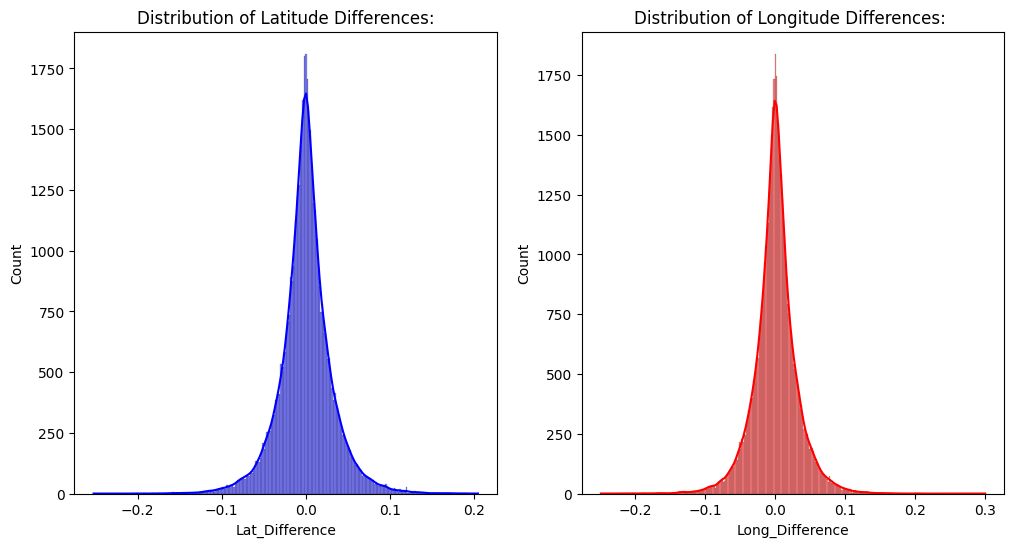

In [ ]:
# Quantitative comparison (original and noisy data)

coord_cleaned['Lat_Difference'] = coord_cleaned['LAT'] - coord_cleaned['Latitude_DP']
coord_cleaned['Long_Difference'] = coord_cleaned['LON'] - coord_cleaned['Longitude_DP']

coord_cleaned['Lat_Difference'] , coord_cleaned['Long_Difference']

# Displaying the distribution of differences

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(coord_cleaned['Lat_Difference'], kde=True, color='blue')
plt.title('Distribution of Latitude Differences:')

plt.subplot(1, 2, 2)
sns.histplot(coord_cleaned['Long_Difference'], kde=True, color='red')
plt.title('Distribution of Longitude Differences: ')

plt.show()


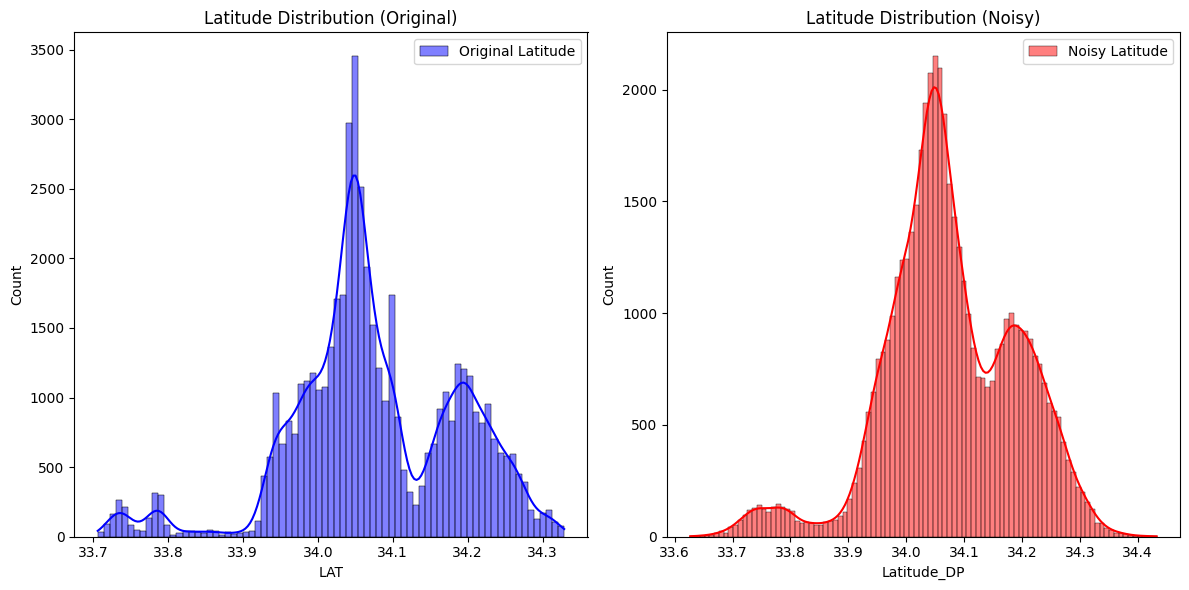

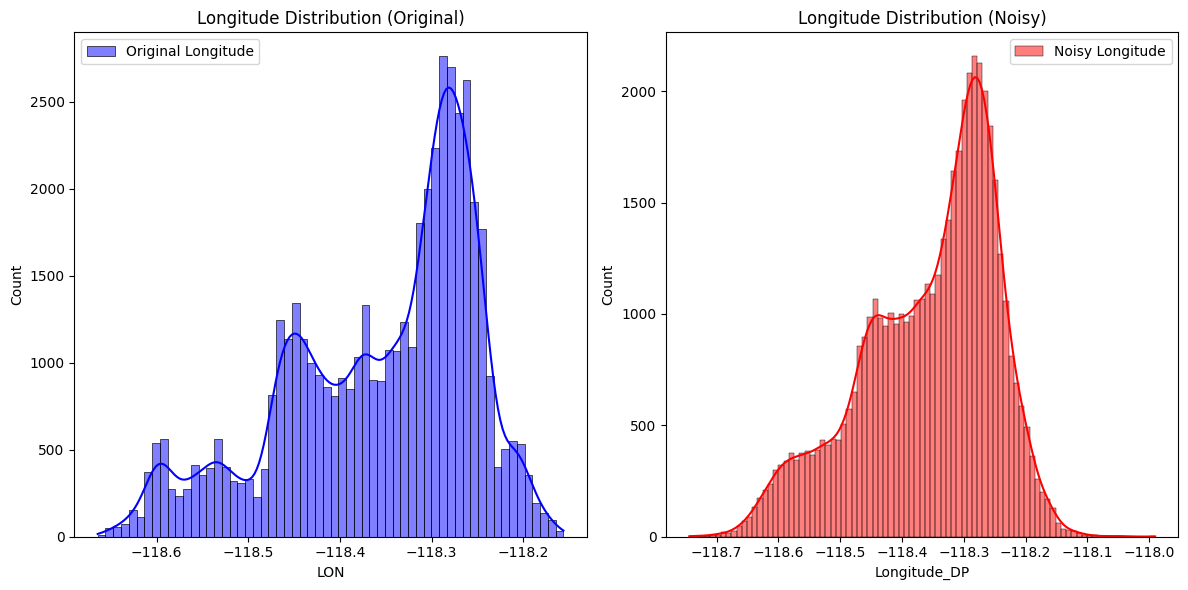

In [ ]:
# Visualizing the distribution of Latitude and Noisy Latitude

plt.figure(figsize=(12, 6))

# Latitude

plt.subplot(1, 2, 1)
sns.histplot(coord_cleaned['LAT'], kde=True, color='blue', label='Original Latitude')

plt.title('Latitude Distribution (Original)')
plt.legend()

# Noisy Latitude

plt.subplot(1, 2, 2)
sns.histplot(coord_cleaned['Latitude_DP'], kde=True, color='red', label='Noisy Latitude')

plt.title('Latitude Distribution (Noisy)')
plt.legend()

plt.tight_layout()
plt.show()

# Visualizing the distribution of Longitude and Noisy Longitude

plt.figure(figsize=(12, 6))

# Longitude

plt.subplot(1, 2, 1)
sns.histplot(coord_cleaned['LON'], kde=True, color='blue', label='Original Longitude')
plt.title('Longitude Distribution (Original)')

plt.legend()

# Noisy Longitude

plt.subplot(1, 2, 2)
sns.histplot(coord_cleaned['Longitude_DP'], kde=True, color='red', label='Noisy Longitude')
plt.title('Longitude Distribution (Noisy)')

plt.legend()

plt.tight_layout()
plt.show()



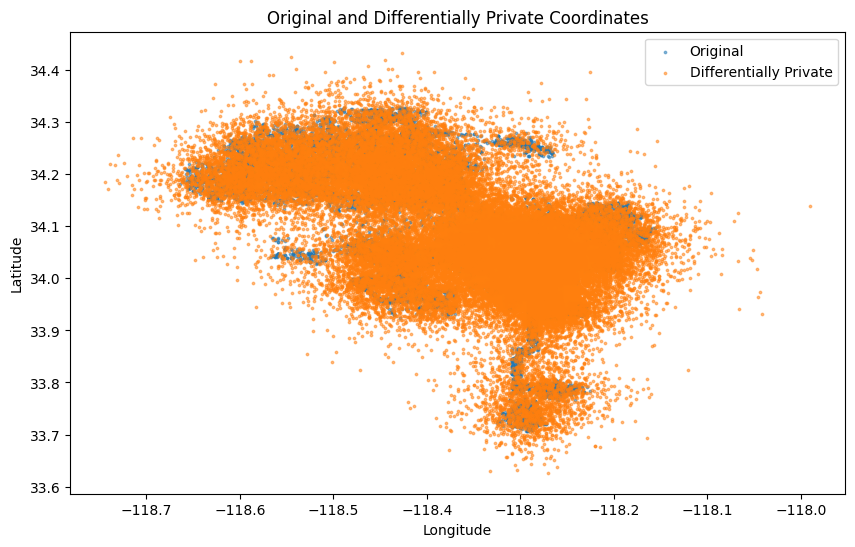

In [ ]:
# original and differentially private coordinates

plt.figure(figsize=(10, 6))

plt.scatter(coord_cleaned['LON'], coord_cleaned['LAT'], alpha=0.5, label='Original', s=3)
plt.scatter(coord_cleaned['Longitude_DP'], coord_cleaned['Latitude_DP'], alpha=0.5, label='Differentially Private', s=3)

plt.title('Original and Differentially Private Coordinates')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()


In [ ]:

# Extracting the necessary columns

lat_clean = coord_cleaned['LAT']
lat_DP_clean = coord_cleaned['Latitude_DP']
lon_clean = coord_cleaned['LON']
lon_DP_clean = coord_cleaned['Longitude_DP']


# Correlation Analysis

lat_corr = lat_clean.corr(lat_DP_clean)
lon_corr = lon_clean.corr(lon_DP_clean)

print(f"Correlation (original and noisy Latitude): {lat_corr}")

print(f"Correlation (original and noisy Longitude): {lon_corr}")



Correlation (original and noisy Latitude): 0.9628329590117056
Correlation (original and noisy Longitude): 0.9585595145065792


Text(0.5, 1.02, 'Correlation between Original and Noisy Latitude')

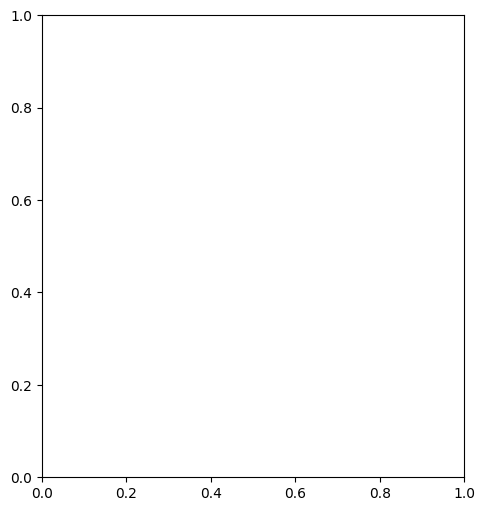

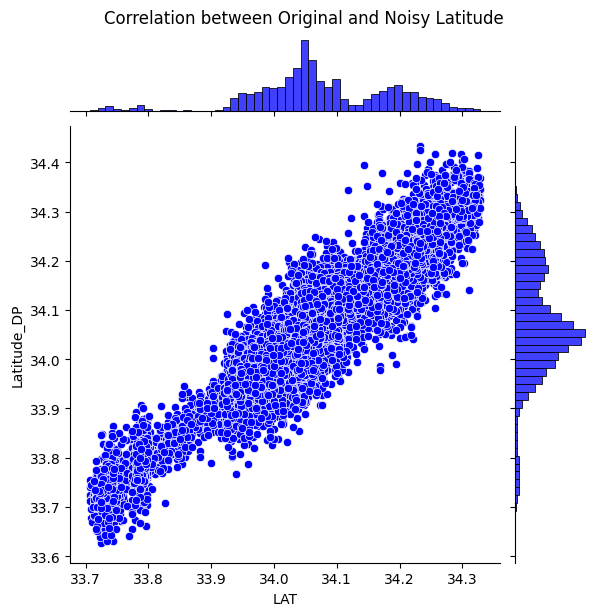

In [ ]:
# Visualization of Correlation (Scatter plot with density)

plt.figure(figsize=(12, 6))

# Latitude Correlation

plt.subplot(1, 2, 1)
sns.jointplot(x=lat_clean, y=lat_DP_clean, kind="scatter", color='blue', marginal_kws=dict(bins=50, fill=True))
plt.suptitle('Correlation between Original and Noisy Latitude', y=1.02)

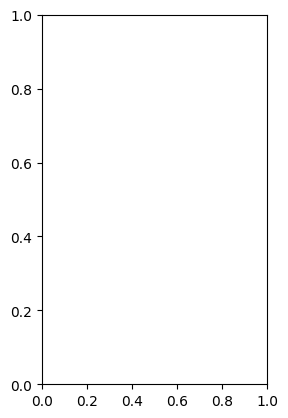

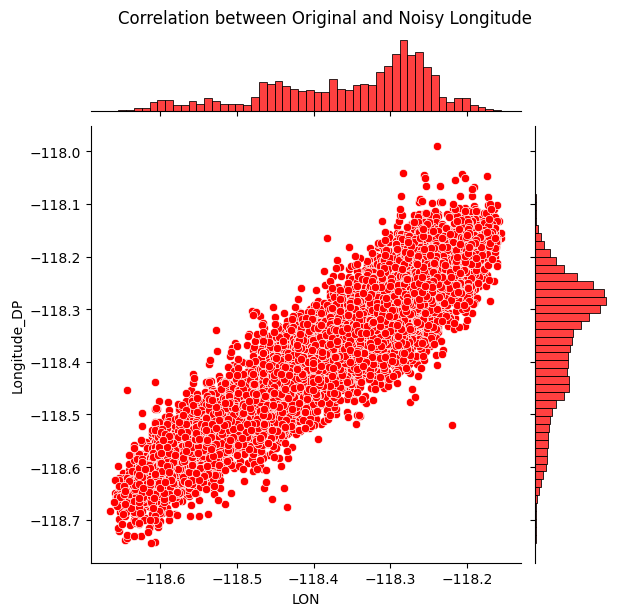

In [ ]:
# Longitude Correlation

plt.subplot(1,  2, 2)
sns.jointplot(x=lon_clean, y=lon_DP_clean, kind="scatter", color='red', marginal_kws=dict(bins=50, fill=True))
plt.suptitle('Correlation between Original and Noisy Longitude', y=1.02)

plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


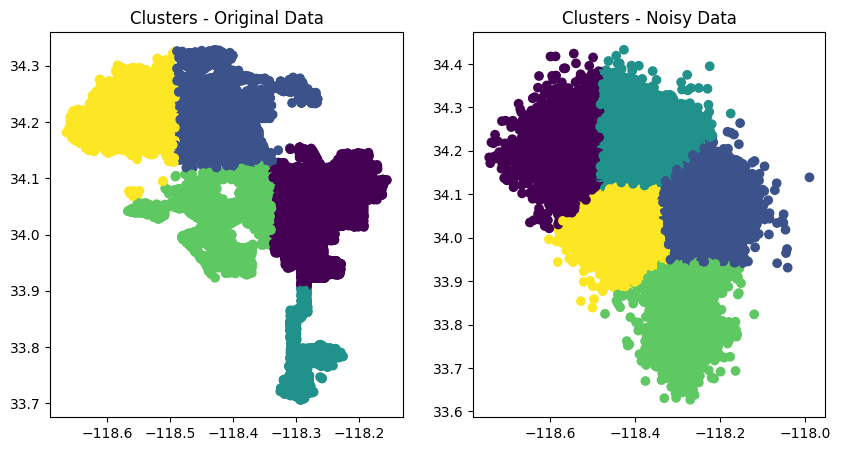

In [ ]:
#Cluster Analysis (K-Means):

# clustering (Original data)

kmeans_o = KMeans(n_clusters=5).fit(coord_cleaned[['LON', 'LAT']])
coord_cleaned['Cluster_Original'] = kmeans_o.labels_

# clustering (Noisy data)

kmeans_n = KMeans(n_clusters=5).fit(coord_cleaned[['Longitude_DP', 'Latitude_DP']])
coord_cleaned['Cluster_Noisy'] = kmeans_n.labels_

# Comparing both clusters

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(coord_cleaned['LON'], coord_cleaned['LAT'], c=coord_cleaned['Cluster_Original'], cmap='viridis')
plt.title('Clusters - Original Data')

plt.subplot(1, 2, 2)
plt.scatter(coord_cleaned['Longitude_DP'], coord_cleaned['Latitude_DP'], c=coord_cleaned['Cluster_Noisy'], cmap='viridis')
plt.title('Clusters - Noisy Data')

plt.show()


In [ ]:

# Changing 'Date OCC' column to datetime format

crime_data_LA['DATE OCC'] = pd.to_datetime(crime_data_LA['DATE OCC'], errors='coerce')  # Convert to datetime
crime_data_LA['DATE OCC'] = crime_data_LA['DATE OCC'].dt.date  # Extracting only the date part

# Displaying first few rows

print(crime_data_LA[['DATE OCC']].head())


# Adding the 'Date OCC' column from 'crime_data' to 'coordinates_cleaned'

coord_cleaned['Date OCC'] = crime_data_LA['DATE OCC']


<ipython-input-17-ca7390018268>:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime_data_LA['DATE OCC'] = pd.to_datetime(crime_data_LA['DATE OCC'], errors='coerce')  # Convert to datetime


     DATE OCC
0  2020-03-01
1  2020-02-08
2  2020-11-04
3  2020-03-10
4  2020-08-17


In [ ]:

# Daily Crime Counts

d_counts = crime_data_LA.groupby(crime_data_LA['DATE OCC']).size()

# Monthly Crime Counts
m_counts = crime_data_LA.groupby([crime_data_LA['DATE OCC'].apply(lambda x: x.year),
                                           crime_data_LA['DATE OCC'].apply(lambda x: x.month)]).size()

# Year-wise Crime Counts

y_counts = crime_data_LA.groupby(crime_data_LA['DATE OCC'].apply(lambda x: x.year)).size()

# Initial few results
print("Daily Crime Counts:\n", d_counts.head(), "\n")
print("Monthly Crime Counts:\n", m_counts.head(), "\n")
print("Yearly Crime Counts:\n", y_counts.head(), "\n")


Daily Crime Counts:
 DATE OCC
2020-01-01    1144
2020-01-02     527
2020-01-03     595
2020-01-04     541
2020-01-05     505
dtype: int64 

Monthly Crime Counts:
 DATE OCC  DATE OCC
2020      1           18542
          2           17272
          3           16183
          4           15699
          5           17219
dtype: int64 

Yearly Crime Counts:
 DATE OCC
2020    199700
2021    209703
2022    234975
2023    231642
2024     68215
dtype: int64 



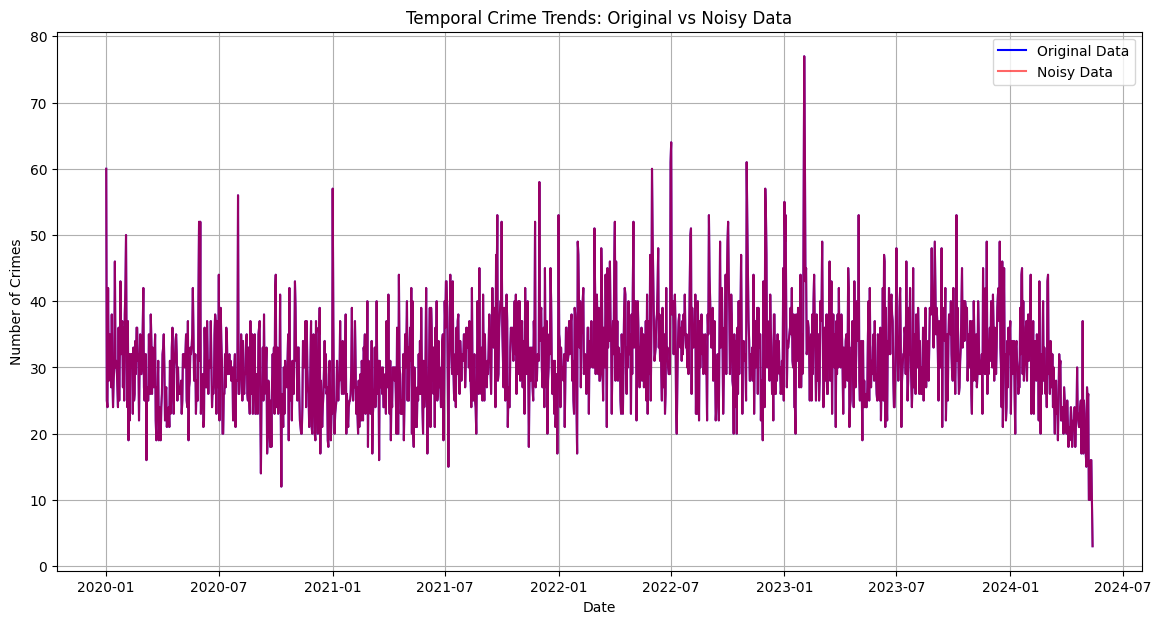

In [ ]:
# Resampling based on (LAT, LON) (original coordinates)

counts_day_o = coord_cleaned.groupby(['Date OCC', 'LAT', 'LON']).size().reset_index(name='Counts')

# Resampling based on (Latitude_DP, Longitude_DP) (noisy coordinates)

counts_day_n = coord_cleaned.groupby(['Date OCC', 'Latitude_DP', 'Longitude_DP']).size().reset_index(name='Counts')

# Aggregating the counts per day (ignoring coordinates for aggregation)

counts_day_o_agg = counts_day_o.groupby('Date OCC')['Counts'].sum()
counts_day_n_agg = counts_day_n.groupby('Date OCC')['Counts'].sum()

# Plotting the time series of crimes per day for original and noisy data

plt.figure(figsize=(14, 7))

# Original Data Time Series

plt.plot(counts_day_o_agg, label='Original Data', color='blue')

# Noisy Data Time Series

plt.plot(counts_day_n_agg, label='Noisy Data', color='red', alpha=0.6)

# plot
plt.title('Temporal Crime Trends: Original vs Noisy Data')
plt.xlabel('Date')
plt.ylabel('Number of Crimes')
plt.legend()
plt.grid(True)

plt.show()


The temporal crime trends have been preserved despite the implementation of differential privacy, as evidenced by the close alignment between the original and noisy datasets. This is a favourable outcome, as it indicates that the temporal structure of the data has not been substantially distorted by the noise that was introduced to safeguard privacy.